# Change Log for CNN


---

- decided to use a dataset for facial expressions.
- messed around with different architectures, found that Sequential suited well.
- changed hyperparameters. Set the learning rate to 0.0001 to keep the model learning at a good enough pace. I found setting it too low would make accuracy worse (about 30% accuracy at 0.1), and too high just makes it learn too slowly.
- validation accuracy did not improve from about 55%. I think it has to do with the layers, more work needs to be done.
- after this log, I was able to get validation accuracy above 80% by changing the layers and the validation split from 30% to 20% (0.2).
- I found that the activation function ReLU works better than ELU, or SELU for this problem.
- I applied batch normalization to a layer to improve the convergence speed, which I think worked out well.
- Augmenting the data provided better results.
- I also tried out gpu acceleration. Tensorflow picks this up automatically if you have a GPU connected, however, I used Google colab. This meant that training the model took a lot less time than it would using a CPU.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# /content/drive/MyDrive/Data/fer2013
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/fer2013/fer2013.csv')
print(df.head())

   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training


In [4]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [5]:
labels_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4:'sadness', 5:'suprise', 6:'neutral'}

In [6]:
df.pixels.loc[0]

'70 80 82 72 58 58 60 63 54 58 60 48 89 115 121 119 115 110 98 91 84 84 90 99 110 126 143 153 158 171 169 172 169 165 129 110 113 107 95 79 66 62 56 57 61 52 43 41 65 61 58 57 56 69 75 70 65 56 54 105 146 154 151 151 155 155 150 147 147 148 152 158 164 172 177 182 186 189 188 190 188 180 167 116 95 103 97 77 72 62 55 58 54 56 52 44 50 43 54 64 63 71 68 64 52 66 119 156 161 164 163 164 167 168 170 174 175 176 178 179 183 187 190 195 197 198 197 198 195 191 190 145 86 100 90 65 57 60 54 51 41 49 56 47 38 44 63 55 46 52 54 55 83 138 157 158 165 168 172 171 173 176 179 179 180 182 185 187 189 189 192 197 200 199 196 198 200 198 197 177 91 87 96 58 58 59 51 42 37 41 47 45 37 35 36 30 41 47 59 94 141 159 161 161 164 170 171 172 176 178 179 182 183 183 187 189 192 192 194 195 200 200 199 199 200 201 197 193 111 71 108 69 55 61 51 42 43 56 54 44 24 29 31 45 61 72 100 136 150 159 163 162 163 170 172 171 174 177 177 180 187 186 187 189 192 192 194 195 196 197 199 200 201 200 197 201 137 58 98 92

In [7]:
np.array(df.pixels.loc[0].split(' ')).reshape(48, 48)

array([['70', '80', '82', ..., '52', '43', '41'],
       ['65', '61', '58', ..., '56', '52', '44'],
       ['50', '43', '54', ..., '49', '56', '47'],
       ...,
       ['91', '65', '42', ..., '72', '56', '43'],
       ['77', '82', '79', ..., '105', '70', '46'],
       ['77', '72', '84', ..., '106', '109', '82']], dtype='<U3')

In [8]:
fig = plt.figure(1, (14, 14))


<Figure size 1400x1400 with 0 Axes>

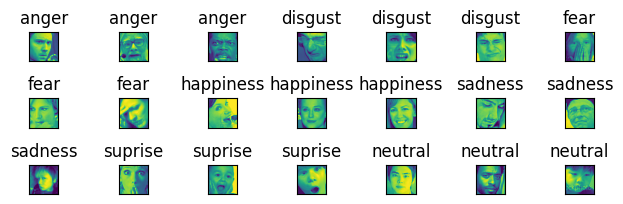

In [9]:
k = 0
for label in sorted(df.emotion.unique()):
    for j in range(3):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(labels_to_text[label])
        plt.tight_layout()

In [10]:
img_array = df.pixels.apply(lambda x : np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))

In [11]:
img_array = np.stack(img_array, axis=0)

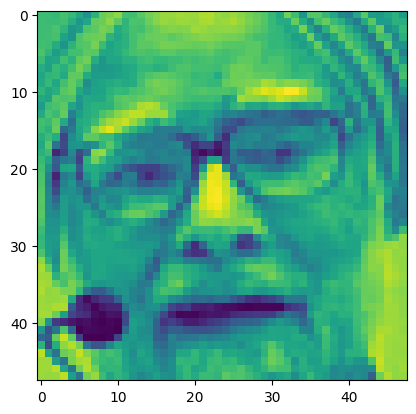

In [12]:
plt.imshow(img_array[1])

In [13]:
labels = df.emotion.values

In [14]:
# split dataset into training and testing parts
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(img_array, labels, test_size = .1)

In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32298, 48, 48, 1), (3589, 48, 48, 1), (32298,), (3589,))

In [17]:
X_train = X_train/255
X_test = X_test/255

In [18]:
import tensorflow as tf

In [19]:
basemodel = tf.keras.models.Sequential([tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape = (48,48,1)),
                                        tf.keras.layers.MaxPool2D(2,2),
                                        #
                                        tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape = (48,48,1)),
                                        tf.keras.layers.MaxPool2D(2,2),
                                        #
                                        tf.keras.layers.Conv2D(128,(3,3),activation='relu',input_shape = (48,48,1)),
                                        tf.keras.layers.MaxPool2D(2,2),
                                        #
                                        tf.keras.layers.Conv2D(256,(3,3),activation='relu',input_shape = (48,48,1)),
                                        tf.keras.layers.MaxPool2D(2,2),
                                        tf.keras.layers.Flatten(),
                                        tf.keras.layers.Dense(1000,activation='relu'),
                                        tf.keras.layers.Dense(7,activation = 'softmax')
                                        ])

In [20]:
basemodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 128)         0

In [21]:
basemodel.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=.0001),
                  loss = 'sparse_categorical_crossentropy',
                  metrics = ['accuracy'])

In [22]:
import os
try:
  os.mkdir('checkpoint')
except:
  pass

In [23]:
file_name = 'best_model.h5'
checkpoint_path= os.path.join('checkpoint',file_name)


call_back = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_accuracy',
                                                 verbose=1,
                                                 save_freq='epoch',
                                                 save_best_only=True,
                                                 save_weights_only=False,
                                                 mode='max')


In [74]:
basemodel.fit(X_train, y_train, epochs=100, validation_split=.2, callbacks=call_back)

Epoch 1/100
800/808 [============================>.] - ETA: 0s - loss: 0.0736 - accuracy: 0.9775
Epoch 1: val_accuracy improved from 0.75944 to 0.76765, saving model to checkpoint/best_model.h5
808/808 [==============================] - 4s 5ms/step - loss: 0.0735 - accuracy: 0.9776 - val_loss: 1.5751 - val_accuracy: 0.7676
Epoch 2/100
803/808 [============================>.] - ETA: 0s - loss: 0.0673 - accuracy: 0.9810
Epoch 2: val_accuracy did not improve from 0.76765
808/808 [==============================] - 5s 6ms/step - loss: 0.0672 - accuracy: 0.9810 - val_loss: 2.0775 - val_accuracy: 0.7025
Epoch 3/100
797/808 [============================>.] - ETA: 0s - loss: 0.0629 - accuracy: 0.9824
Epoch 3: val_accuracy did not improve from 0.76765
808/808 [==============================] - 5s 6ms/step - loss: 0.0625 - accuracy: 0.9826 - val_loss: 1.8415 - val_accuracy: 0.7299
Epoch 4/100
808/808 [==============================] - ETA: 0s - loss: 0.0611 - accuracy: 0.9822
Epoch 4: val_accurac

KeyboardInterrupt: 

In [ ]:
# After a bit of trial and error, I get around 75% validation accuracy.

In [27]:
final_model = tf.keras.models.load_model(checkpoint_path)

In [28]:
#import all the requirements
import numpy as np
import os
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

In [29]:
TF_LITE_MODEL_FILE_NAME = "best_model.tflite"

In [30]:
# write a tflite file to be used with android
converter = tf.lite.TFLiteConverter.from_keras_model(final_model)
tflite_model = converter.convert()

with open(TF_LITE_MODEL_FILE_NAME, 'wb') as f:
    f.write(tflite_model)

# References
https://www.youtube.com/watch?v=T3yR9DZT2mQ&t=1852s
